Insufficient successful data for large_scale in world0_20x20-goalBehindWall (only 1 trial(s)).
Comparison DataFrame:


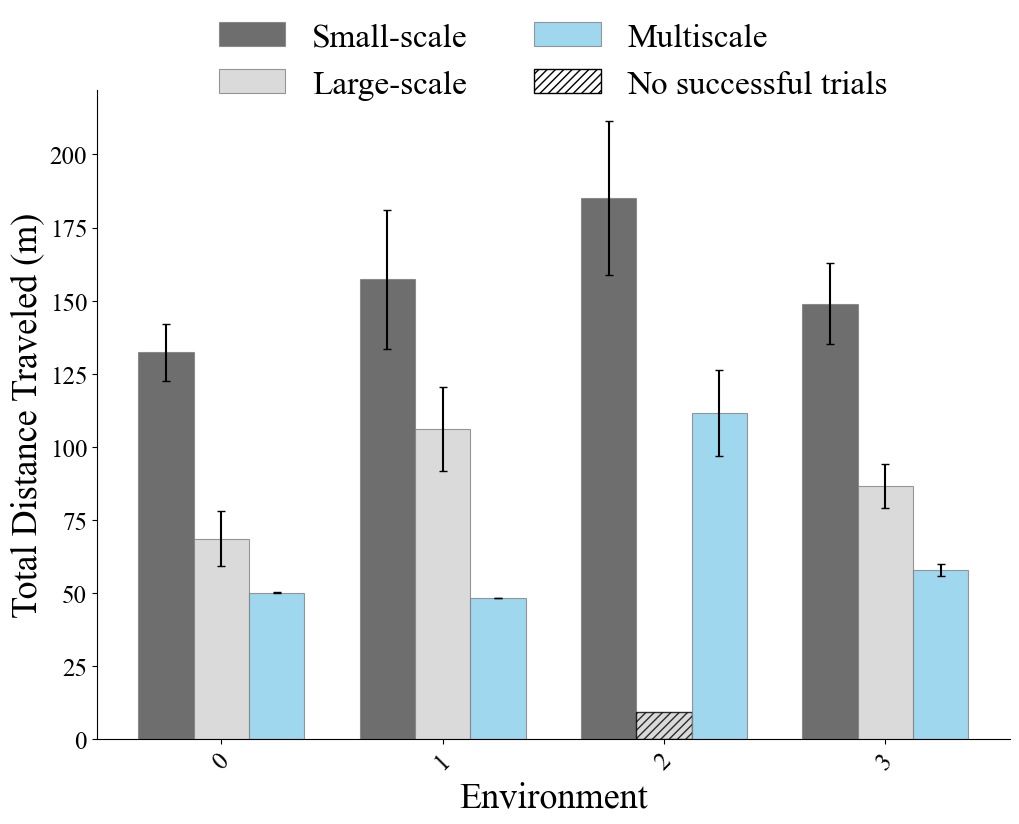

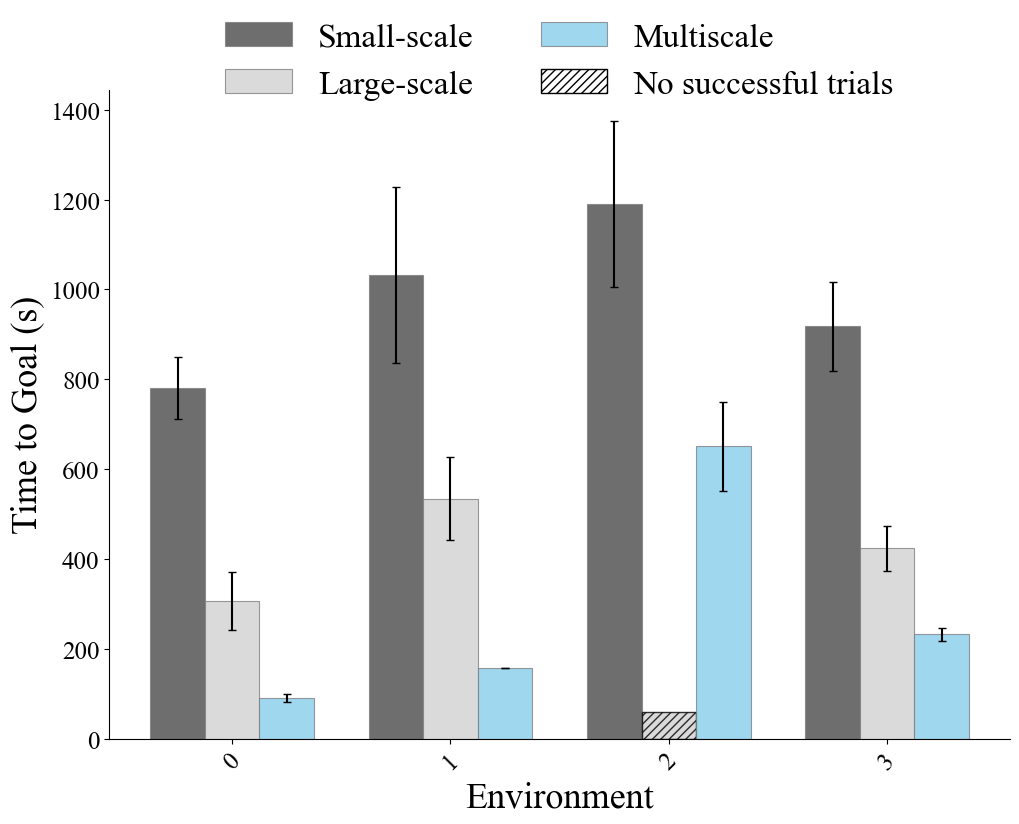

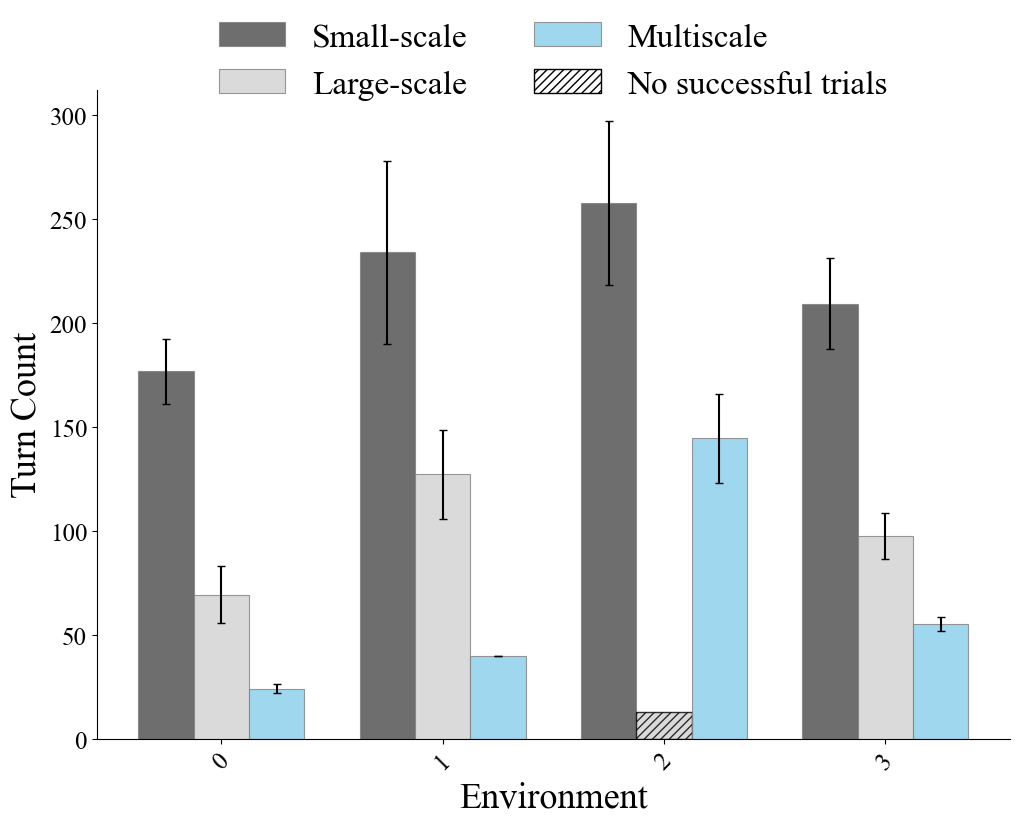

                          world         mode  total_distance_traveled_mean  \
0                  world0_20x20      vanilla                    132.256000   
1                  world0_20x20  large_scale                     68.536000   
2                  world0_20x20   multiscale                     50.043636   
3        world0_20x20-obstacles      vanilla                    157.272000   
4        world0_20x20-obstacles  large_scale                    106.118000   
5        world0_20x20-obstacles   multiscale                     48.380000   
6   world0_20x20-goalBehindWall      vanilla                    185.165000   
7   world0_20x20-goalBehindWall   multiscale                    111.396000   
8       world0_20x20-2obstacles      vanilla                    148.927000   
9       world0_20x20-2obstacles  large_scale                     86.549000   
10      world0_20x20-2obstacles   multiscale                     57.679000   

    total_time_secs_mean  turn_count_mean  total_distance_trave

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from matplotlib.patches import Patch  # For custom legend patches

# Use Times New Roman font for the plots
rcParams['font.family'] = 'Times New Roman'

# Define the base directories for "vanilla", "multiscale", and "large_scale" modes
vanilla_base_dir = r"c:/Users/bduke/OneDrive - University of Cincinnati/Desktop/RESEARCH/workdir/place_cell_model/AlabiHippocampalModel/controllers/bek_controller/analysis/stats/vanilla"
multiscale_base_dir = r"c:/Users/bduke/OneDrive - University of Cincinnati/Desktop/RESEARCH/workdir/place_cell_model/AlabiHippocampalModel/controllers/bek_controller/analysis/stats/multiscale"
large_scale_base_dir = r"c:/Users/bduke/OneDrive - University of Cincinnati/Desktop/RESEARCH/workdir/place_cell_model/AlabiHippocampalModel/controllers/bek_controller/analysis/stats/large_scale"

# Define the worlds to analyze
worlds = [
    "world0_20x20",
    "world0_20x20-obstacles",
    "world0_20x20-goalBehindWall",
    "world0_20x20-2obstacles"
]

# Specify the corner to analyze
corner_to_analyze = (8, -8)

def load_json_for_corner(directory, corner):
    """
    Loads all JSON files from the specified directory for which the filename
    indicates the given corner and where the JSON data has "success": True.
    """
    data = []
    if not os.path.exists(directory):
        return pd.DataFrame()
    
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            try:
                parts = filename.split("_")
                x_coord = int(parts[-2])
                y_coord = int(parts[-1].split(".")[0])
                if (x_coord, y_coord) != corner:
                    continue
            except (IndexError, ValueError):
                print(f"Error parsing corner from filename: {filename}")
                continue
            
            with open(os.path.join(directory, filename), 'r') as f:
                file_data = json.load(f)
                # Append only if success is exactly True
                if file_data.get("success") is True:
                    data.append(file_data)
    
    return pd.DataFrame(data)

# Metrics to compare
metrics = ['total_distance_traveled', 'total_time_secs', 'turn_count']

# Create a dictionary to store data for comparison.
# (Only add data when there are > 1 successful trials; otherwise, we will use a placeholder.)
comparison_data = {
    "world": [],
    "mode": [],
    **{f"{metric}_mean": [] for metric in metrics},
    **{f"{metric}_sem": [] for metric in metrics}
}

# Iterate through each world
for world in worlds:
    # Define directories for the current world in each mode
    vanilla_dir = os.path.join(vanilla_base_dir, world, "JSON")
    multiscale_dir = os.path.join(multiscale_base_dir, world, "JSON")
    large_scale_dir = os.path.join(large_scale_base_dir, world, "JSON")
    
    # Load data for the specified corner in all modes
    vanilla_df = load_json_for_corner(vanilla_dir, corner_to_analyze)
    multiscale_df = load_json_for_corner(multiscale_dir, corner_to_analyze)
    large_scale_df = load_json_for_corner(large_scale_dir, corner_to_analyze)
    
    # For each mode, add a record if we have sufficient (more than one) successful trial;
    # otherwise, skip (we’ll handle plotting a placeholder later).
    for mode, df in zip(["vanilla", "large_scale", "multiscale"],
                        [vanilla_df, large_scale_df, multiscale_df]):
        if len(df) > 1:
            comparison_data["world"].append(world)
            comparison_data["mode"].append(mode)
            for metric in metrics:
                comparison_data[f"{metric}_mean"].append(df[metric].mean())
                comparison_data[f"{metric}_sem"].append(df[metric].sem())
        else:
            print(f"Insufficient successful data for {mode} in {world} (only {len(df)} trial(s)).")

# Convert the dictionary to a DataFrame for easier plotting
comparison_df = pd.DataFrame(comparison_data)
print("Comparison DataFrame:")

# --- Modified Plotting Section with Distinct Hatch Pattern for Missing Data ---

for idx, metric in enumerate(metrics):
    fig, ax = plt.subplots(figsize=(10, 8))  # Smaller figure size
    x = np.arange(len(worlds))  # Base indices for worlds
    width = 0.25  # Width for each bar in the group
    
    # Define custom colors for each mode
    colors = {
        "vanilla": "#4a4a4a",
        "large_scale": "#d1d1d1",
        "multiscale": "#87CEEB"
    }
    
    # Determine a maximum value for the metric to help set a minimal placeholder height
    if not comparison_df.empty and comparison_df[f"{metric}_mean"].max() > 0:
        max_val = comparison_df[f"{metric}_mean"].max()
    else:
        max_val = 1
    # Use 5% of the max value as a minimal height so that the hatch pattern is visible.
    placeholder_height = 0.05 * max_val
    
    # Dictionary to track if we have already added the label for each mode
    mode_label_added = {"vanilla": False, "large_scale": False, "multiscale": False}
    
    # Loop over each mode and world, plotting each bar individually
    for i, mode in enumerate(["vanilla", "large_scale", "multiscale"]):
        for j, w in enumerate(worlds):
            xpos = j + (i - 1) * width  # Adjust x position for grouping
            # Filter the DataFrame for this mode and world
            row = comparison_df[(comparison_df["mode"] == mode) & (comparison_df["world"] == w)]
            if not row.empty:
                mean_val = row[f"{metric}_mean"].values[0]
                sem_val = row[f"{metric}_sem"].values[0]
                # Add the mode label only once for the legend.
                label_val = None
                if not mode_label_added[mode]:
                    if mode == "vanilla":
                        label_val = "Small-scale"
                    elif mode == "large_scale":
                        label_val = "Large-scale"
                    elif mode == "multiscale":
                        label_val = "Multiscale"
                    mode_label_added[mode] = True
                ax.bar(
                    xpos,
                    mean_val,
                    width=width,
                    yerr=sem_val,
                    color=colors[mode],
                    alpha=0.8,
                    capsize=3,
                    edgecolor="gray",
                    linewidth=0.8,
                    label=label_val
                )
            else:
                # For missing data, plot a placeholder bar using a hatch pattern.
                ax.bar(
                    xpos,
                    placeholder_height,
                    width=width,
                    color=colors[mode],
                    alpha=0.8,
                    hatch='////',  # Distinct hatch pattern for missing data
                    edgecolor="black",
                    linewidth=1
                )
    
    # Set x-axis ticks to show each world index (or you can replace with custom labels)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{i}" for i in range(len(worlds))], rotation=45, fontsize=18)

    ax.tick_params(axis='y', labelsize=18)
    
    # Define y-axis labels for each metric
    y_labels = ["Total Distance Traveled (m)", "Time to Goal (s)", "Turn Count"]
    ax.set_ylabel(y_labels[idx], fontsize=26)
    ax.set_xlabel("Environment", fontsize=26)
    
    # Remove top and right borders for a cleaner look
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # Create a custom legend entry for missing data using a patch with the hatch pattern.
    missing_patch = Patch(facecolor='white', hatch='////', edgecolor='black', label='No successful trials')
    handles, labels = ax.get_legend_handles_labels()
    # Append the missing-data patch if not already present
    if 'No successful trials' not in labels:
        handles.append(missing_patch)
        labels.append('No successful trials')
    
    # Place the legend above the plot
    ax.legend(handles=handles, labels=labels, loc="upper center", frameon=False, fontsize=24, ncol=2, bbox_to_anchor=(0.5, 1.15))
    plt.tight_layout(pad=0)
    plt.show()

print(comparison_df)

In [61]:
max_dist = 30
sigma_d = 3
n_hd = 8

# Compute the number of preferred distances per head direction
N_dist = len(np.arange(0, max_dist, sigma_d / 2))

# Preferred distances for each BVC
d_i = np.tile(np.arange(0, max_dist, sigma_d / 2), n_hd)[np.newaxis, :]

# Total number of BVC neurons
num_bvc = d_i.size

num_bvc

160